In [1]:
import networkx as nx
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import random
import numpy as np
import math

In [2]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [12.0, 7.0]
mpl.rcParams['figure.dpi'] = 100

In [3]:
# hyperparameters

seed = random.randint(1, 1000)                              # random seed

# Step 1
## Graph generation, train/test splitting and feature generation

Generate/import graph from avalible `generator` classes

In [4]:
from lib.generators.LFR import LFR
from lib.generators.OLP import OLP


generator = LFR(n=5000, t1=3, t2=1.1, m=0.1, seed=seed)
feature_names = generator.feature_names

Generating LFR graph...
Graph generated!
Train/test splitting...
Done splitting the data!
Calculating ['RAI', 'JC', 'AAI', 'PA'] features...
Done calculating


In [5]:
link_prediction_train, link_prediction_test, classifier_test = generator.TRAIN1_DF, generator.TEST1_DF, generator.TEST2_DF

In [6]:
link_prediction_train['goal'].value_counts()

0.0    2978
1.0    2978
Name: goal, dtype: int64

In [7]:
link_prediction_test['goal'].value_counts()

0.0    1873952
1.0        673
Name: goal, dtype: int64

In [8]:
classifier_test['goal'].value_counts()

0.0    1873957
1.0        668
Name: goal, dtype: int64

# Step 2
## Link prediction model

Predict links using one of the avalble link prediction models

In [9]:
from lib.link_prediction_models.RandomForestOnFeatures import RandomForestOnFeatures

model = RandomForestOnFeatures(X_train=link_prediction_train[feature_names], Y_train=link_prediction_train['goal'], random_state=seed)

prob = model.predict_proba(link_prediction_test[feature_names])
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_train.join(prob)
link_proba.head(5)

,node1,node2,goal,RAI,JC,AAI,PA,prob
0,1139,4480,0.0,0.0,0.0,0.0,0.008333,0.000000
1,3568,4552,0.0,0.0,0.0,0.0,0.025000,0.000000
2,379,2189,0.0,0.0,0.0,0.0,0.008333,0.000000
3,375,2781,0.0,0.0,0.0,0.0,0.025000,0.552270
4,2244,4518,0.0,0.0,0.0,0.0,0.033333,0.207972


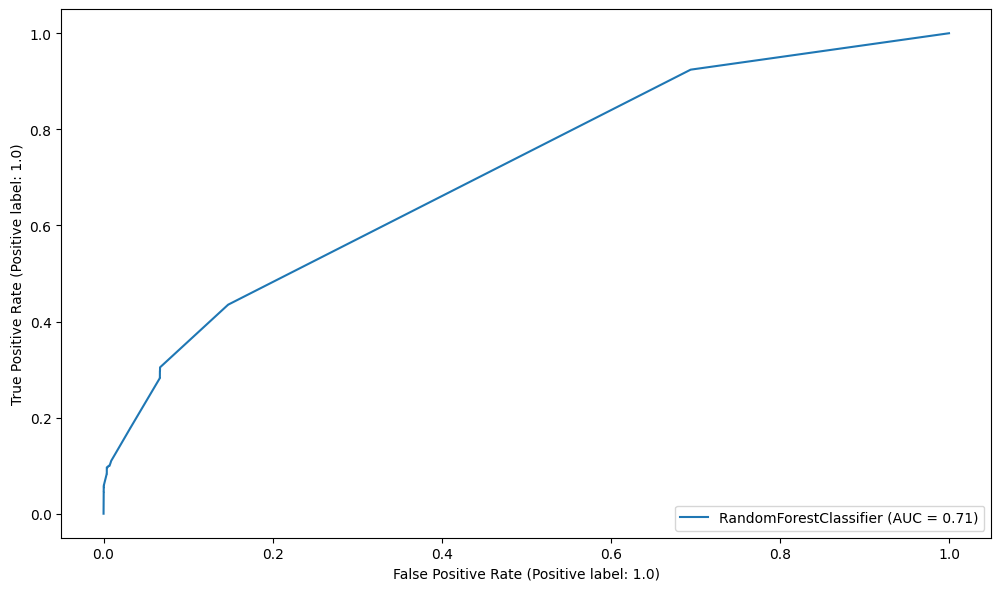

In [10]:
from sklearn import metrics


metrics.plot_roc_curve(model.get_model(), link_prediction_test[feature_names], link_prediction_test['goal'])  

# Step 3
## Quality class analisys

In [11]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba.head()

,node1,node2,goal,RAI,JC,AAI,PA,prob,abs_error
0,1139,4480,0.0,0.0,0.0,0.0,0.008333,0.000000,0.000000
1,3568,4552,0.0,0.0,0.0,0.0,0.025000,0.000000,0.000000
2,379,2189,0.0,0.0,0.0,0.0,0.008333,0.000000,0.000000
3,375,2781,0.0,0.0,0.0,0.0,0.025000,0.552270,0.552270
4,2244,4518,0.0,0.0,0.0,0.0,0.033333,0.207972,0.207972


In [12]:
# statistics on error
link_proba['abs_error'].describe()

count    5956.000000
mean        0.496837
std         0.354082
min         0.000000
25%         0.207972
50%         0.447730
75%         0.792028
max         1.000000
Name: abs_error, dtype: float64

In [13]:
median_error = link_proba['abs_error'].median()
median_error

0.44772963060749116

In [14]:
link_proba['quality_label'] = link_proba.apply(lambda row: 1 if row['abs_error'] <= median_error else 0, axis=1)
link_proba.head()

,node1,node2,goal,RAI,JC,AAI,PA,prob,abs_error,quality_label
0,1139,4480,0.0,0.0,0.0,0.0,0.008333,0.000000,0.000000,1
1,3568,4552,0.0,0.0,0.0,0.0,0.025000,0.000000,0.000000,1
2,379,2189,0.0,0.0,0.0,0.0,0.008333,0.000000,0.000000,1
3,375,2781,0.0,0.0,0.0,0.0,0.025000,0.552270,0.552270,0
4,2244,4518,0.0,0.0,0.0,0.0,0.033333,0.207972,0.207972,1


In [15]:
link_proba['quality_label'].value_counts()

1    3009
0    2947
Name: quality_label, dtype: int64

# Step 4
## Quality class prediction

In [16]:
# train for quality class prediction
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

clf = LogisticRegression(random_state=seed)  #clf = LogisticRegression(random_state=seed, class_weight='balanced')
#clf = clf = DecisionTreeClassifier(random_state=seed)
#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=seed)

clf.fit(link_proba[feature_names], link_proba['quality_label'])

LogisticRegression(random_state=925)

In [17]:
# testing the classifier

pred = clf.predict(classifier_test[feature_names])
pred = pd.Series(pred, name='predicted_quality_label')

proba = model.predict_proba(classifier_test[feature_names])
proba = pd.Series(proba, name='prediction_probability')

classifier_test = classifier_test.join(proba)
classifier_test = classifier_test.join(pred)

classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['prediction_probability']), axis=1)
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: 1 if row['true_abs_error'] <= median_error else 0, axis=1)
classifier_test.head(5)

,node1,node2,goal,RAI,JC,AAI,PA,prediction_probability,predicted_quality_label,true_abs_error,true_quality_label
0,2,1296,1.0,0.0,0.0,0.0,0.009375,0.207972,1,0.792028,0
1,6,4910,1.0,0.0,0.0,0.0,0.028125,0.552270,1,0.447730,1
2,7,207,1.0,0.0,0.0,0.0,0.012500,0.207972,1,0.792028,0
3,9,295,1.0,0.0,0.0,0.0,0.046875,0.620510,0,0.379490,1
4,10,4816,1.0,0.0,0.0,0.0,0.031250,0.574304,1,0.425696,1


In [18]:
classifier_test[['true_quality_label']].value_counts()

true_quality_label
1                     1748627
0                      125998
dtype: int64

In [19]:
classifier_test[['predicted_quality_label']].value_counts()

predicted_quality_label
1                          1850715
0                            23910
dtype: int64

In [20]:
from sklearn import metrics

y_true, y_pred = classifier_test['true_quality_label'], classifier_test['predicted_quality_label']

scores_df = pd.DataFrame()
scores_df['Metric'] = pd.Series(['Sample length', 'Accuracy', 'Precision', 'Recall', 'F1 score'])

scores_df['Score'] = pd.Series([
    len(classifier_test),
    clf.score(classifier_test[feature_names], classifier_test['true_quality_label']),
    metrics.precision_score(y_true, y_pred, average='macro'),
    metrics.recall_score(y_true, y_pred, average='micro'),
    metrics.f1_score(y_true, y_pred, average='weighted')
])

scores_df

,Metric,Score
0,Sample length,1.874625e+06
1,Accuracy,9.447772e-01
2,Precision,9.572319e-01
3,Recall,9.447772e-01
4,F1 score,9.267569e-01


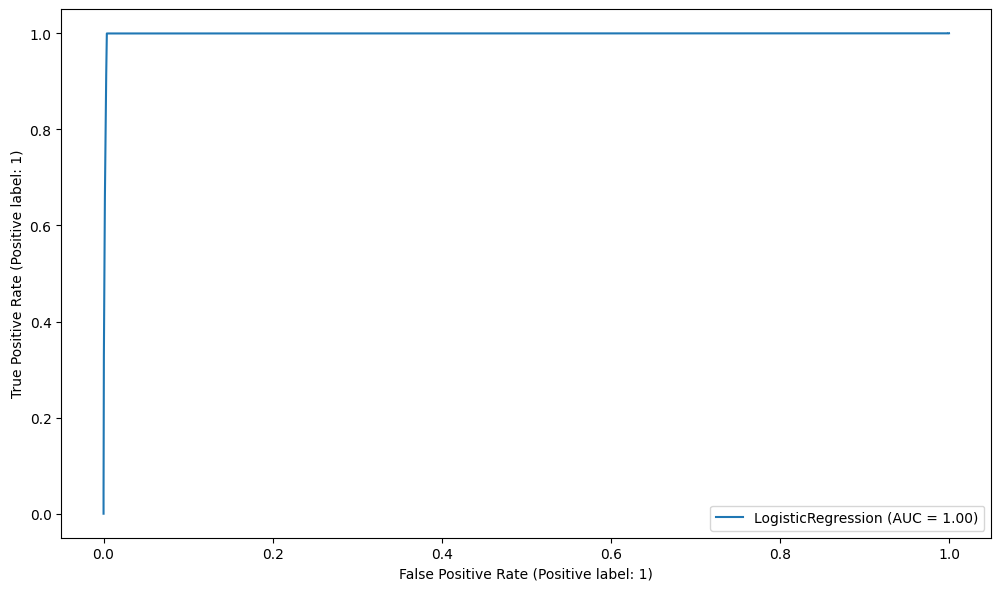

In [21]:
metrics.plot_roc_curve(clf, classifier_test[feature_names], classifier_test['true_quality_label'])  

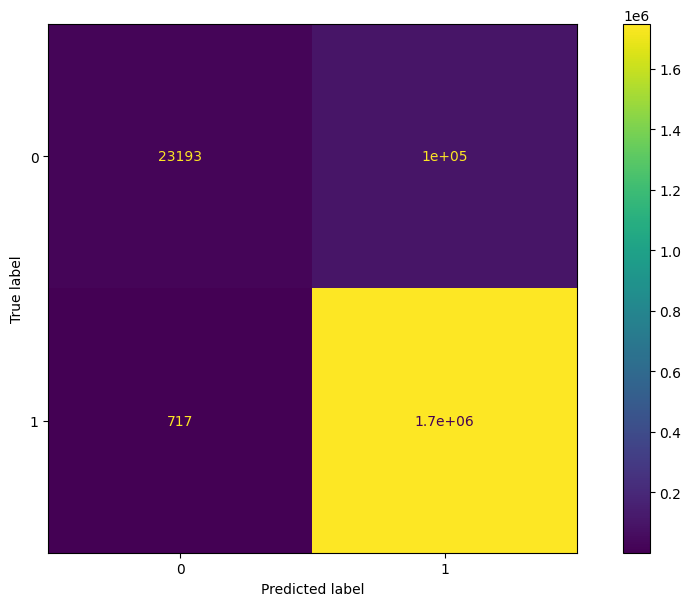

In [22]:
metrics.plot_confusion_matrix(clf, classifier_test[feature_names], classifier_test['true_quality_label'])